# Analysis of off rates
----

Kinetic analysis is a big part of what we use to describe and test biophysical processes. Far and away the most common analysis is that of a unimolecular dissociation process. This simplest of cases is described by the following rate equation.   
  
  
$\begin{align}
\frac{d}{dt}P(t) = -k P(t)
\end{align}$  
  
  
The following notebook explores how sampling and fitting of the above process affects the conclusions we draw from our analysis. The take-home message is that we should always shoot for more numbers, but there are diminishing returns. A second message is that we should always analyze the complementary cumulative distribution (CCDF) of the measured probability distribution (PDF), rather than analyze the PDF itself. 
  
To show this, we are going to generate a mess of measured PDFs for a range of off rates, $k$, sampled at various $N$s. 


In [1]:
%matplotlib notebook

rates = [10,1,.1,.01,.001]
samples = [50,100,500,1000]

<IPython.core.display.Javascript object>


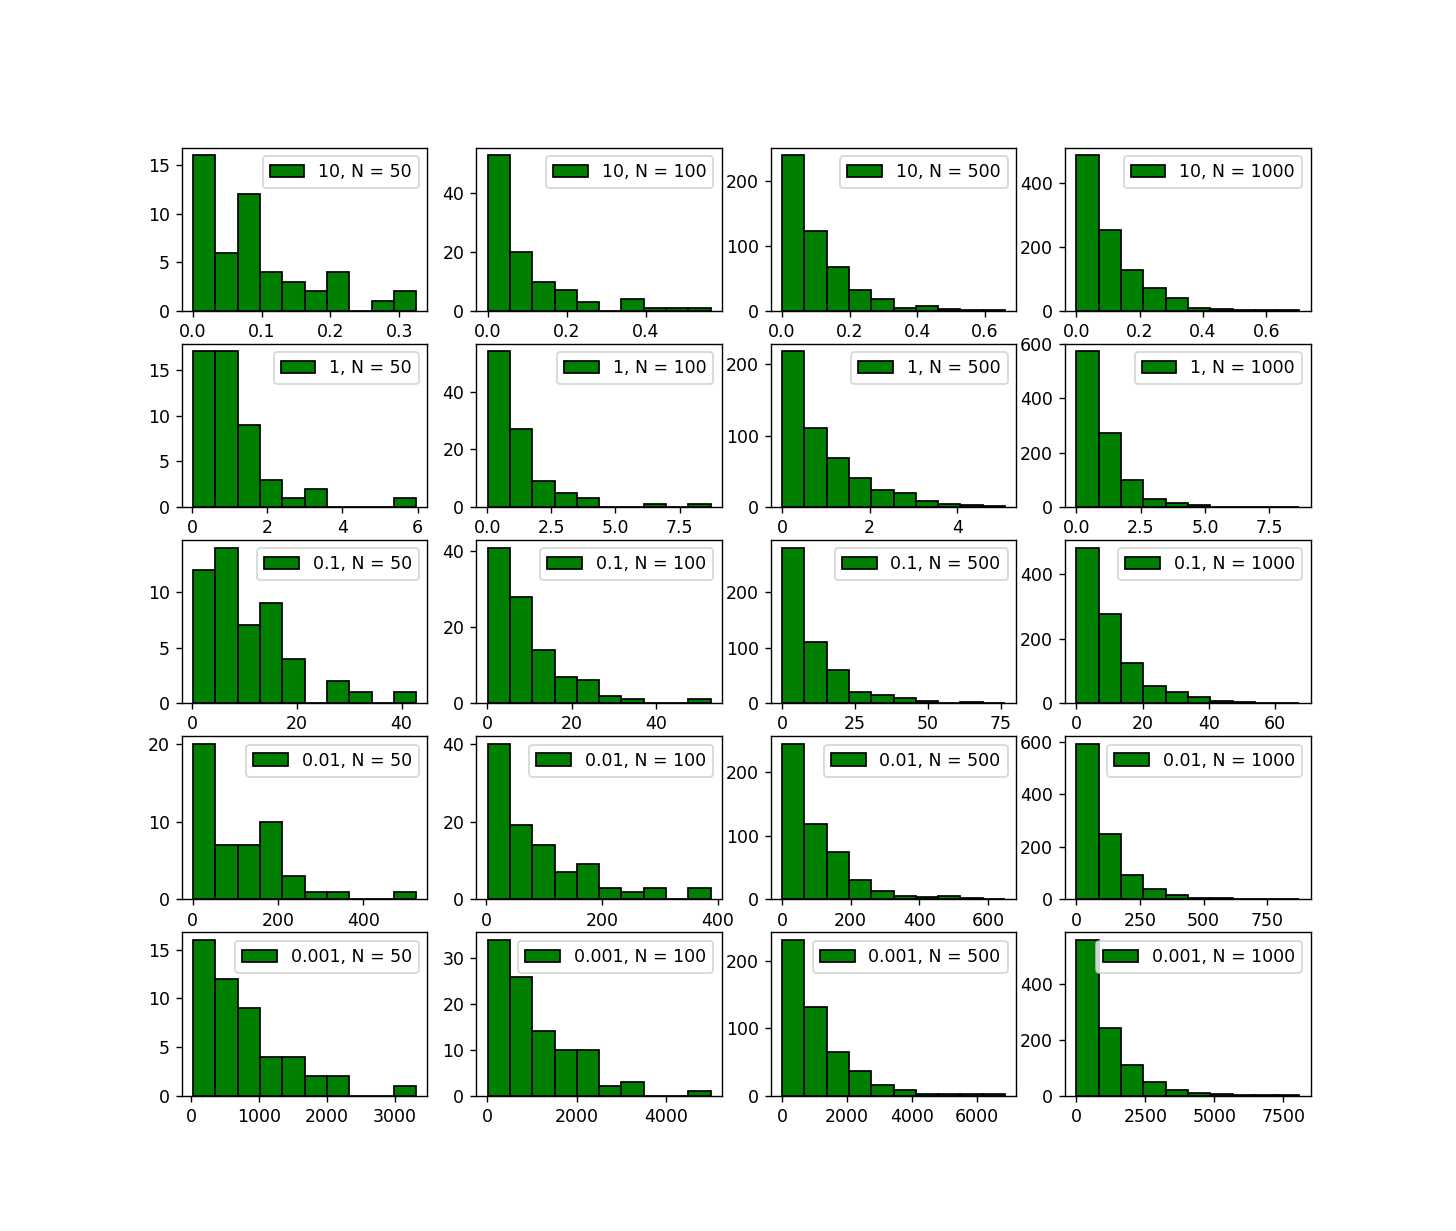

In [2]:
import numpy as np
import random as ra
import matplotlib.pyplot as plt
from itertools import product

fig, axes = plt.subplots(nrows=5, ncols=4)
axlist = [i for i in axes.flat]

count = 0
for x in list(product(rates, samples)):
    
    #- generate a list of eponentially distributed random numbers
    lifetimes = [ra.expovariate(x[0]) for i in range(x[1])]
    
    axlist[count].hist(lifetimes, label = str(x[0])+", N = "+str(x[1])
                  , facecolor = 'g', edgecolor = 'k')
    axlist[count].legend(shadow=False, fancybox=True)
    count+=1

Note how the distributions get "sloppier" at lower samplings. These distributions represent the would-be culmination of an entire single molecule measurement. For some data, $n$ are hard to come by, even the lowest $N$ here, 50, in some cases would be luxurious. After the measurement, the next step would be to determine the rate parameter $k$, which can be done by fitting the histogram of measured lifetimes, or the PDF,  to an exponential function.

In [3]:
from scipy.optimize import curve_fit

#- Definition of an exponential function
def exp_func(x, a, b):
    return a*np.exp(-b*x)

<IPython.core.display.Javascript object>


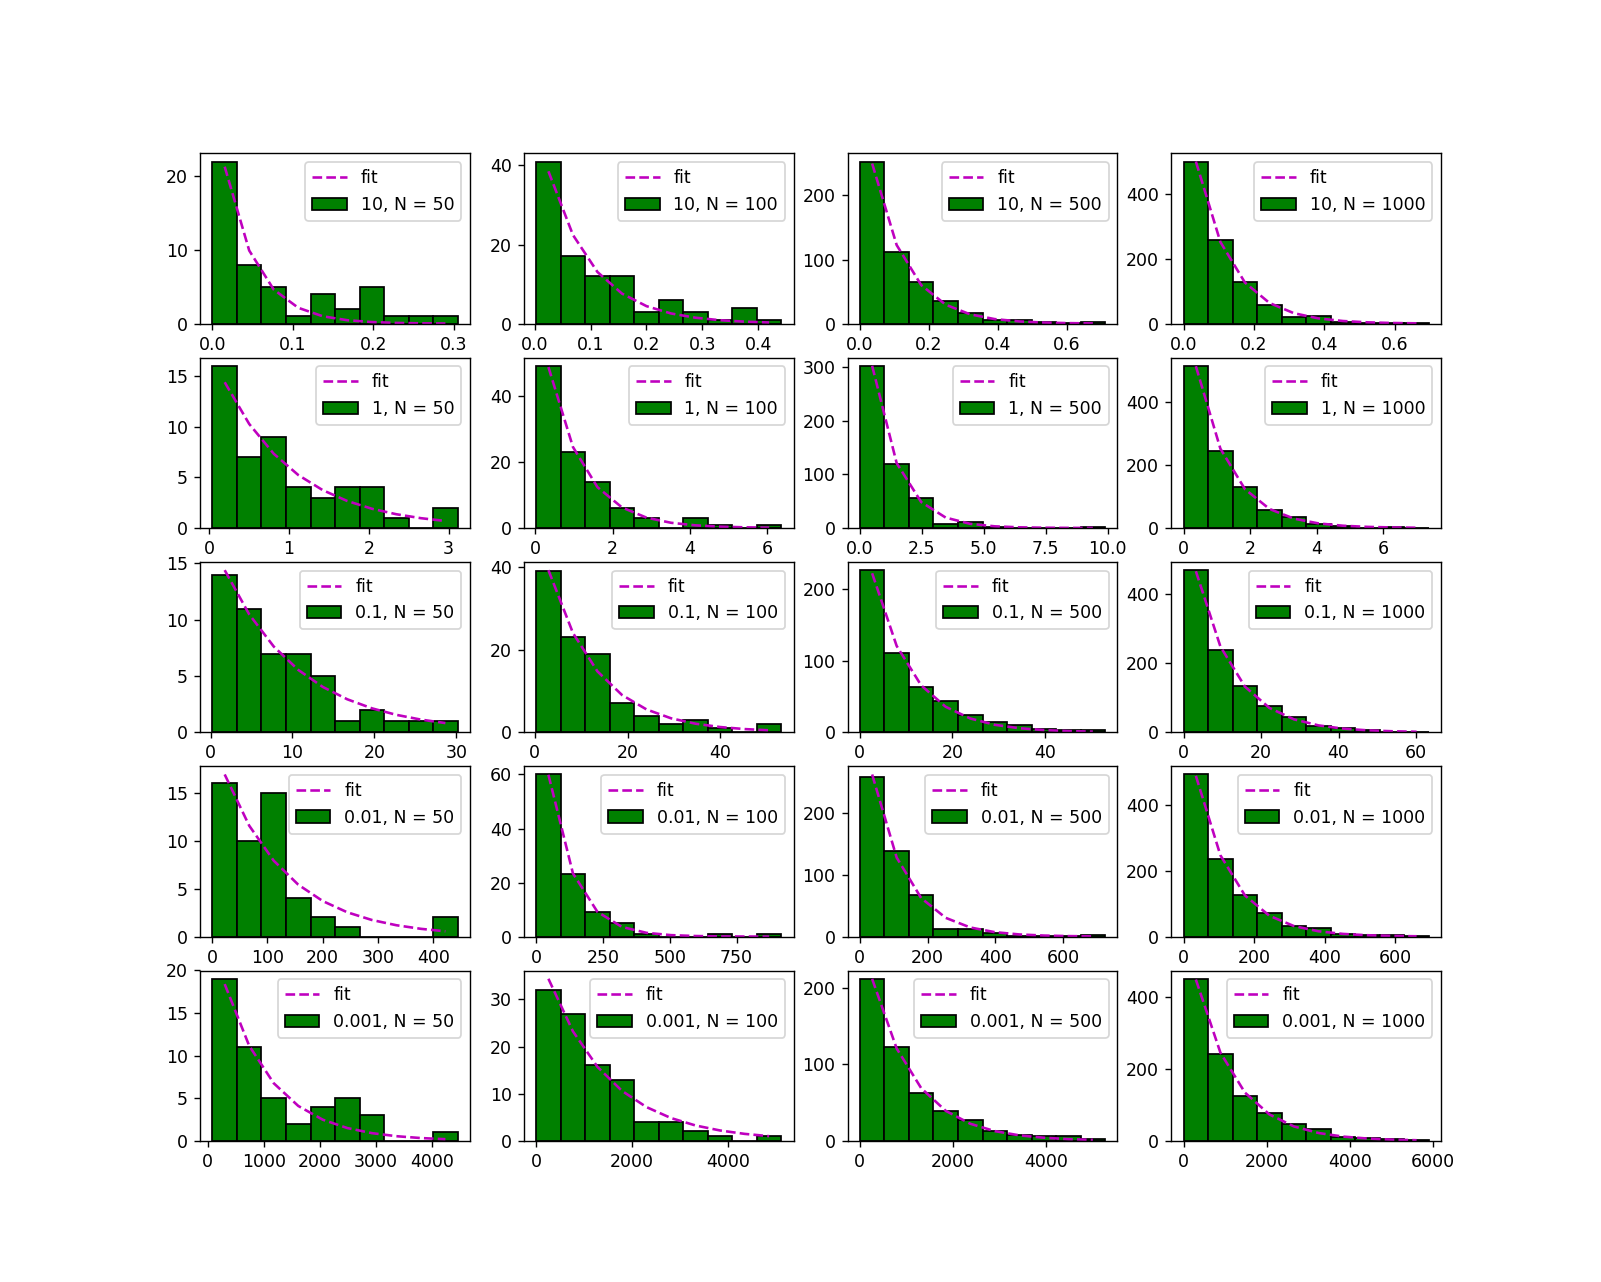

In [4]:
fig, axes = plt.subplots(nrows=5, ncols=4)
axlist = [i for i in axes.flat]

count = 0
for x in list(product(rates, samples)):
    lifetimes = [ra.expovariate(x[0]) for i in range(x[1])]
    n, bins, patches = axlist[count].hist(lifetimes, label = str(x[0])+", N = "+str(x[1])
                  , facecolor = 'g', edgecolor = 'k')
    bin_centers = bins[:-1] + np.diff(bins) / 2
    popt, pcov = curve_fit(exp_func, bin_centers, n, p0 = [n[0], x[0]])

    axlist[count].plot(bin_centers, exp_func(bin_centers, *popt),'m--', label='fit')
    axlist[count].legend(loc = 1,shadow=False, fancybox=True)
    count+=1

Again, it is super obvious just how important sampling is from the low $n$ data on the left. But, what I want to get a handle on just how wide the variation is in measured $k$'s. If we had 1000 parallel labs all measuring the same off-rate, how different would all of the results be? Which is to say, how off of the mark might we potentially be when after our extended labors we finally determine our $k$.

In [8]:
from ipywidgets import FloatProgress
from IPython.display import display

#- This is how many times we are going to simulate 
#- the whole process for each value, N and k.
N = 1000

#- this is just a dumb status bar.
f = FloatProgress(min=0, max=N*len(list(product(rates, samples))))
display(f)

count = 0
fitted_rates_histfit = []
for x in list(product(rates, samples)):
    tmp = []
    for j in range(N):
        lifetimes = [ra.expovariate(x[0]) for i in range(x[1])]
        n, bins = np.histogram(lifetimes)
        bin_centers = bins[:-1] + np.diff(bins) / 2
        try:
            popt, pcov = curve_fit(exp_func, bin_centers, n, p0 = [n[0], x[0]])
            tmp.append(popt[1])
        except RuntimeError:
            pass
        f.value += 1
    fitted_rates_histfit.append(tmp) 
    

FloatProgress(value=0.0, max=20000.0)

<IPython.core.display.Javascript object>


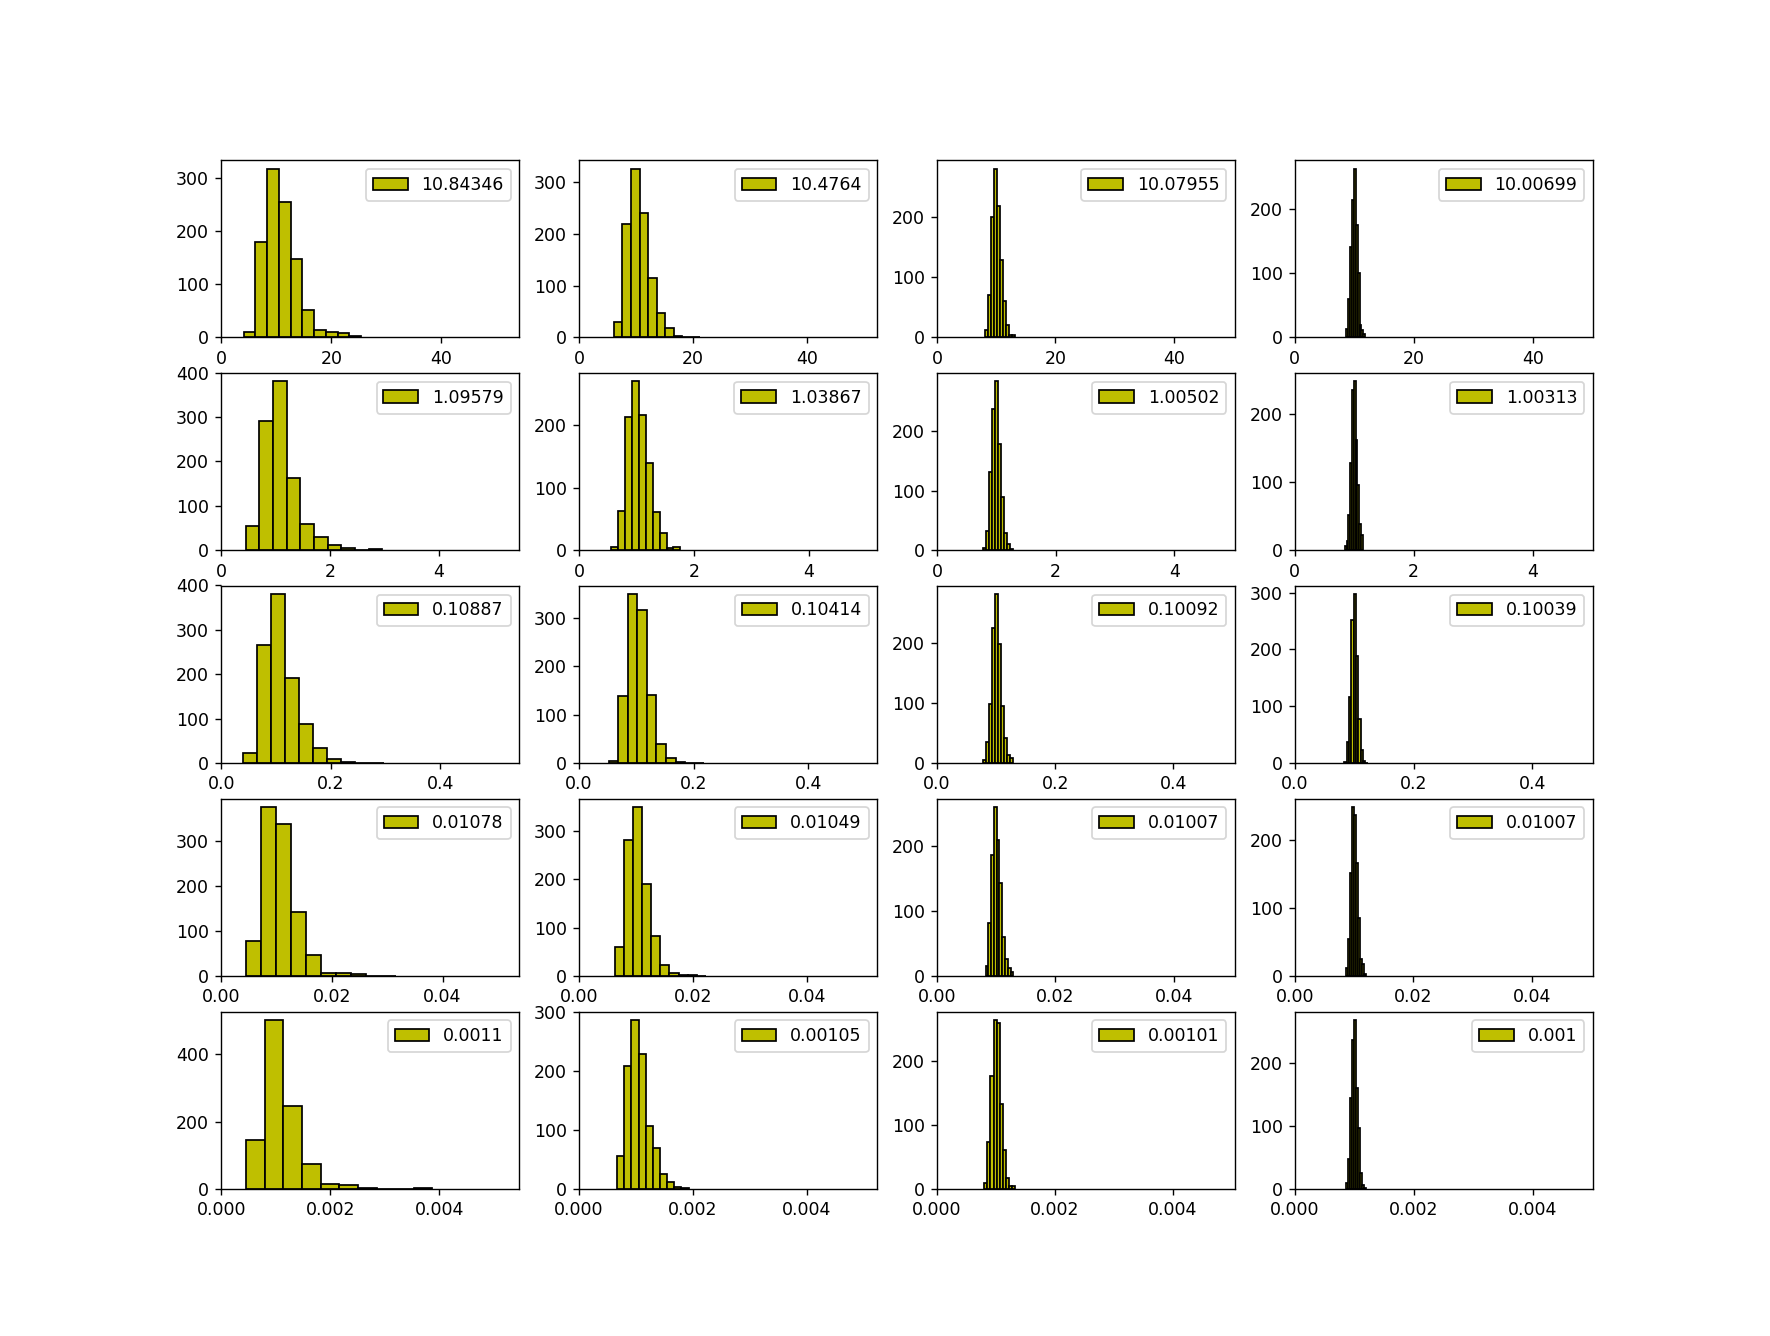

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=4)
axlist = [i for i in axes.flat]
count = 0
for x in fitted_rates_histfit:
    axlist[count].hist(x, facecolor = 'y', edgecolor = 'k', label = (str(round(np.mean(x),5))))
    axlist[count].legend(loc = 1,shadow=False, fancybox=True)
    axlist[count].set_xlim(0,5*np.mean(x))
    count+=1

This fits with our intuition, the larger the sample size, the better the fit. There are two other comments I want to make about these data. First, the fitted rate seems to be systematically overestimated ralative to the true value of $k$. I've not made an effort to learn the origin of this bias, its just noted because I think it's interesting. However, you can drive this bias and with it the error by adding a baseline to the fit. Try it out.
  
`def exp_func(x, a, b, c):
    return a*np.exp(-b*x)+c`
  


Second, its important to remember that _"statistics mean nothing to the individual &trade;_" and upon completion of your experiments, _i.e._ a single sampling of one of the above distributions, you may have sampled from deep in the tail of the distribution, selecting an "outlier" rate. You have no way of knowing without more data, so we should always keep that in mind when making comparisons to other measurments and literature values and when we fashion narratives around our own results. Luckily, we can do ourselves a favor, and instead of analyzing the PDF, as above, we instead analyze the CCDF. 
  
  
The complementary cummulative distribution, also known in this case as the survival distribution, is a measure of how much of the population persists after some time $t$. 
  
  
$\begin{align}
S(t) = 1- \int_0^t P(\tau) d\tau
\end{align}$  
  
  

The CCDF has a couple of huge advantages over the PDF. 
* No need to be rational about how binsizes are defined.
* The CCDF is uniquely defined by a single variable, insted of two

And, most importantly,
* The estimate of survival at any $t$ is the result of measurements of all $n>t$.

I'll come back to this point in a bit, because the outcome means that the error on survival estimates are at a minimum at $t=0$ and are an increasing function.


In [10]:
def Survival(pdf, stepsize):
    #- accepts 1-D array of lifetime data and int stepsize
    ccdf = []
    steps = []
    for i in np.arange(0, max(lifetimes), stepsize):
        temp = 0
        for j in pdf:
            if j>i:
                temp+=1
        ccdf.append(temp/len(lifetimes))
        steps.append(i)
    return(steps, ccdf)

<IPython.core.display.Javascript object>


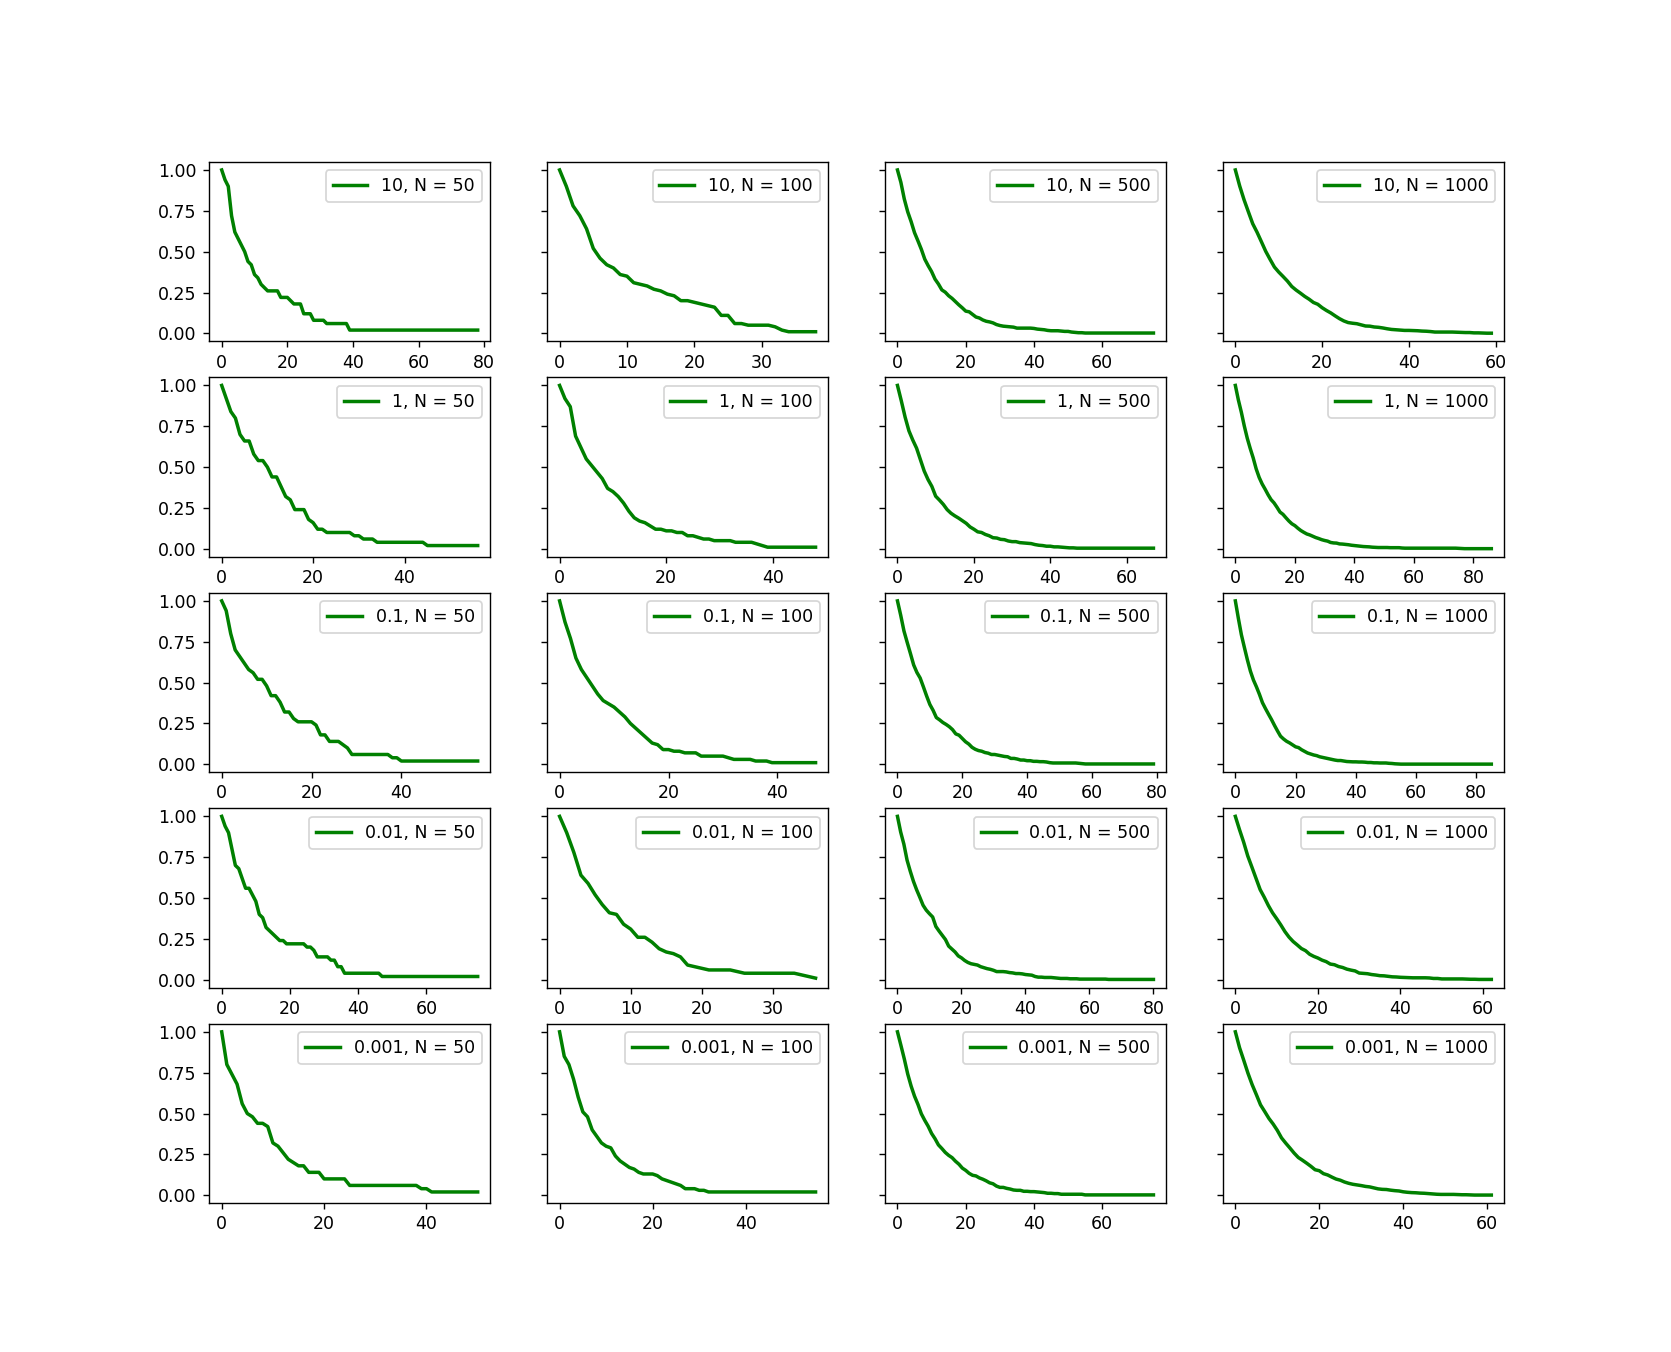

In [11]:
fig, axes = plt.subplots(nrows=5, ncols=4, sharey = True)
axlist = [i for i in axes.flat]

rates = [10,1,.1,.01,.001]
samples = [50,100,500,1000]

count = 0
for x in list(product(rates, samples)):
    lifetimes = [ra.expovariate(x[0]) for i in range(x[1])]
    dt = (1/(10*x[0]))
    comp_dist = Survival(lifetimes, dt)
    axlist[count].plot(comp_dist[1], "g", linewidth = 2, label = str(x[0])+", N = "+str(x[1]))
    axlist[count].legend(shadow=False, fancybox=True, loc =1)
    count+=1


I mean, just look at them. They look fantastic. So much better that the histograms of the PDF. Lets fit each of these with a single variable exponential function.

<IPython.core.display.Javascript object>


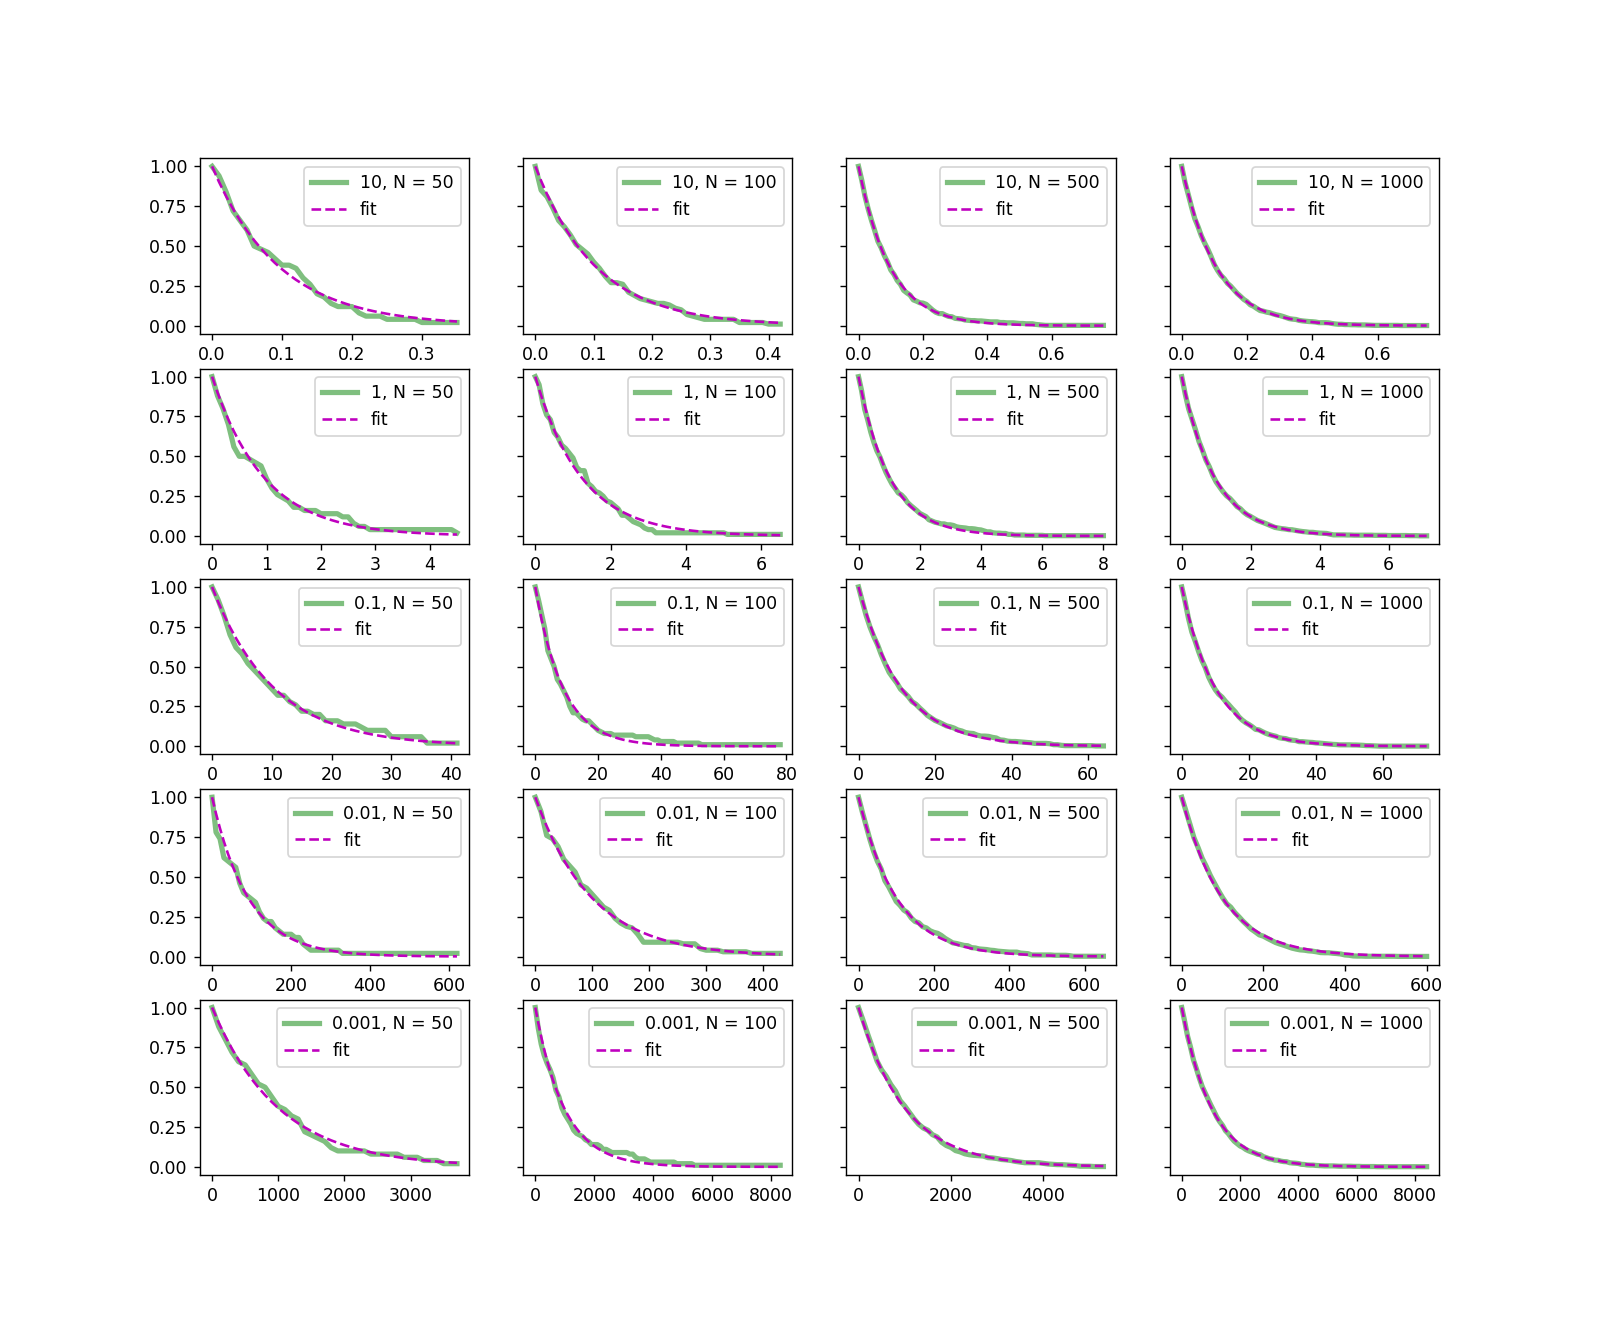

In [12]:
def exp_func_0(x, b):
    return np.exp(-b*x)

fig, axes = plt.subplots(nrows=5, ncols=4, sharey = True)
axlist = [i for i in axes.flat]

rates = [10,1,.1,.01,.001]
samples = [50,100,500,1000]

count = 0
for x in list(product(rates, samples)):
    lifetimes = [ra.expovariate(x[0]) for i in range(x[1])]
    dt = (1/(10*x[0]))
    comp_dist = Survival(lifetimes, dt)

    popt, pcov = curve_fit(exp_func_0,comp_dist[0],comp_dist[1], p0 = [x[0]])
   
    axlist[count].plot(comp_dist[0],comp_dist[1], "g", linewidth = 3, label = str(x[0])+", N = "+str(x[1]), alpha = 0.5)
    axlist[count].plot(comp_dist[0], exp_func_0(np.array(comp_dist[0]), *popt), "m--",label='fit')
    axlist[count].legend(shadow=False, fancybox=True, loc =1)
    count+=1


Just as it was obvious that fitting the PDF histograms was problematic, these fits look really problem-less-tic. But before we run a bunch of synthetic data through the analysis to see just how good it is, lets consider why these look so much better. The survival probability is calculated by asking how many of our events which started at time $t=0$ are still ongoing at time $t=\tau$, where $\tau$ is just some later time. This means when we calculate a survival of $90\%$, $90\%$ of the data goes into determining that position in the curve. The same is true at all points along the curve, such that as you progress further and further out into the survival curve in time, the more noisy the estimate of survival becomes. This isn't true in the PDF. There, the entirety of the data is partitioned into several bins, so that the error in the height of each bin is proportional to how well you've sampled the distibution within the bounds of that individual bin.

  
  
Returning to the point about how the error grows in the survival curve as the number of survivors are diminished, I usually apply a right-handed censoring of the data. That is, I truncate the CCDF to avoind the tail of the distribution. In practise you should choose a truncation value rationally based on your sampling depth and the nature of your kinetic process, but for the purposes below, and a general rule of thumb, I have chosen a cutoff at $10\%$. So lets now simulate the sampling and analysis to look to the distributions of expected rate measurments using this strategy.

In [18]:
N = 1000

f = FloatProgress(min=0, max=N*len(list(product(rates, samples))))
display(f)
count = 0
fitted_rates_surv_log_fit = []


for x in list(product(rates, samples)):
    tmp = []
    dt = (1/(10*x[0]))
    for j in range(N):
        lifetimes = [ra.expovariate(x[0]) for i in range(x[1])]
        comp_dist = Survival(lifetimes, dt)

        trunc_prob = [i for i in comp_dist[1] if i >= .1]
        trunc_x = comp_dist[0][:len(trunc_prob)]
        try:
            popt, pcov = curve_fit(exp_func_0, trunc_x, trunc_prob, p0 = [x[0]])
            tmp.append(popt[0])
        except RuntimeError:
            pass
        f.value += 1
    fitted_rates_surv_log_fit.append(tmp) 
    

FloatProgress(value=0.0, max=20000.0)

<IPython.core.display.Javascript object>


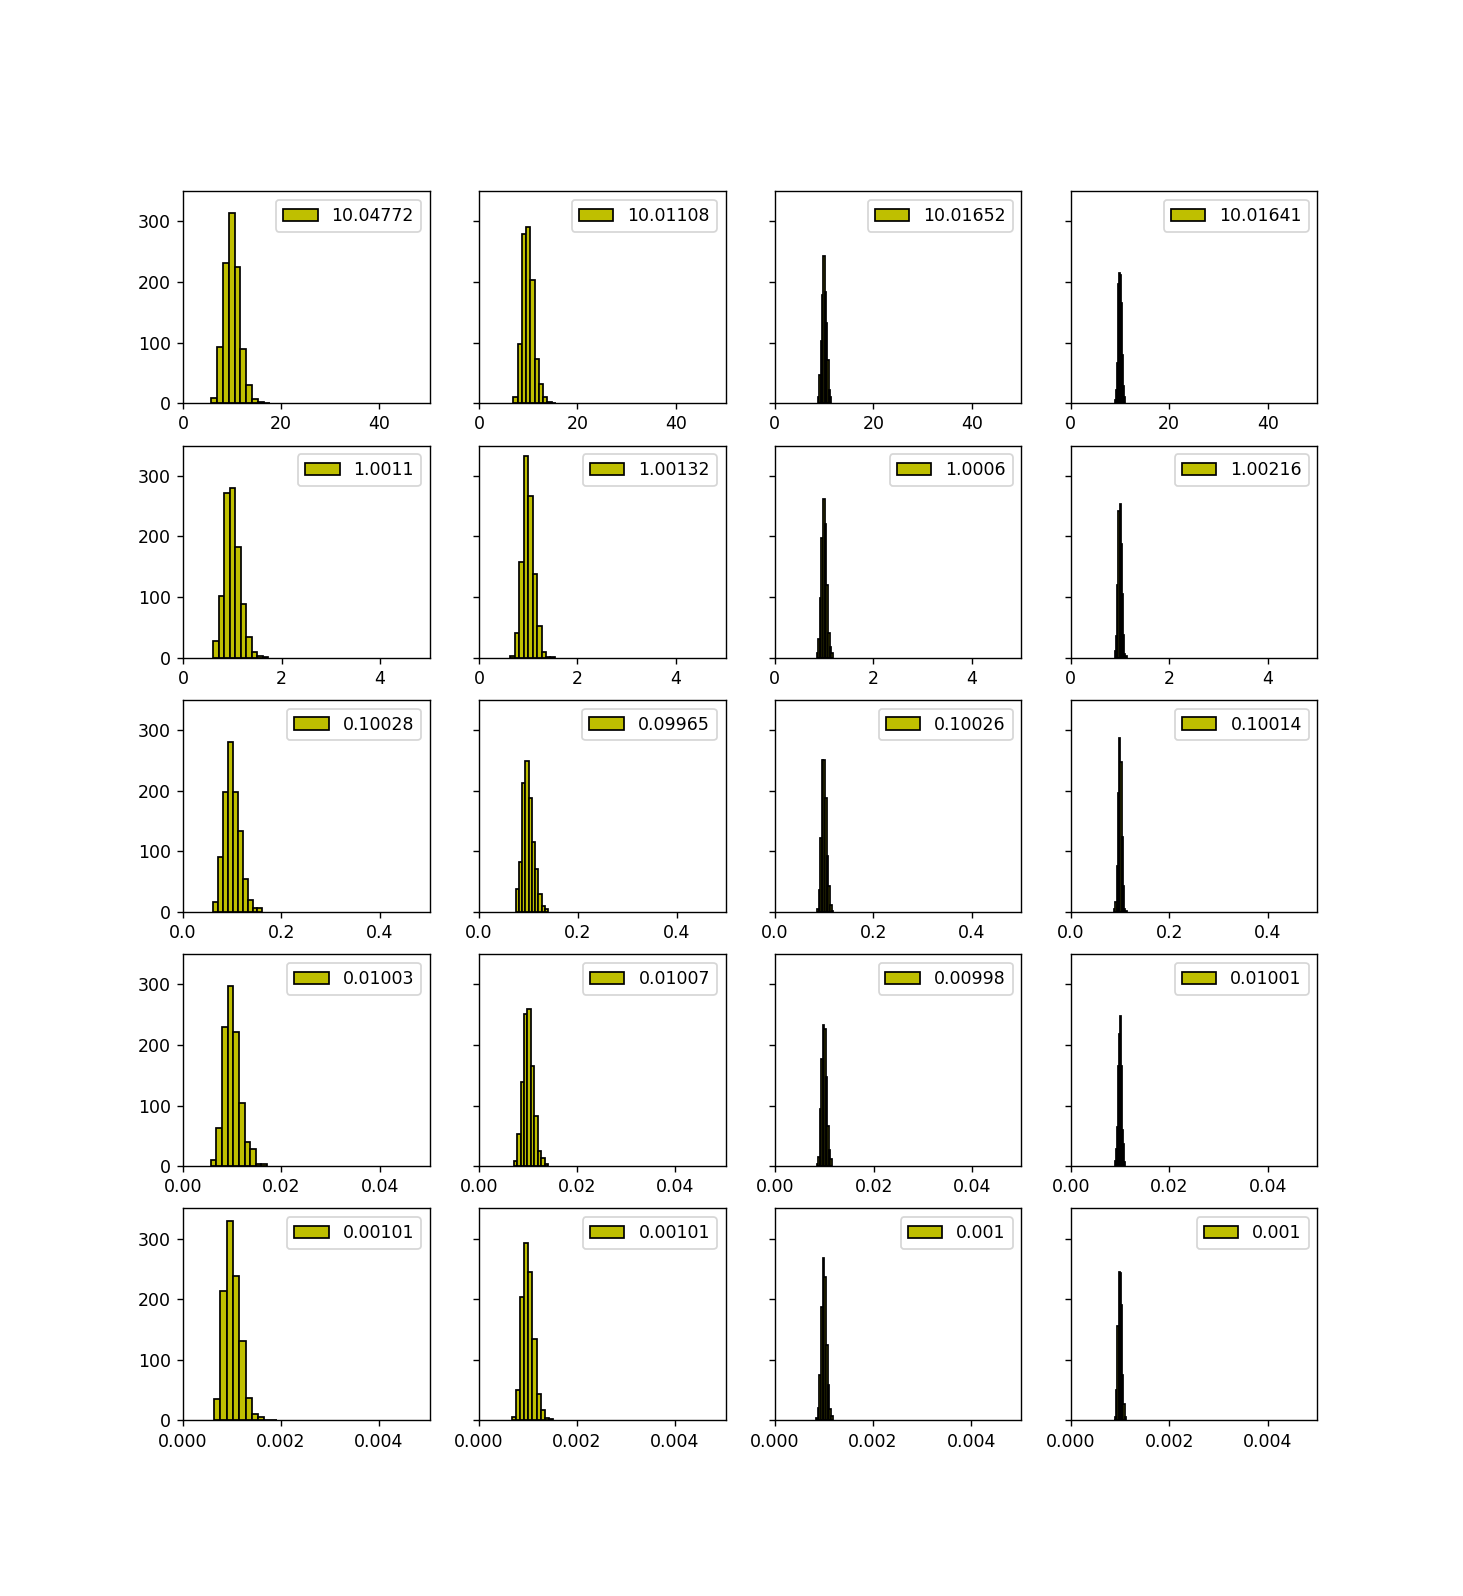

In [19]:
fig, axes = plt.subplots(nrows=5, ncols=4, sharey = True)
axlist = [i for i in axes.flat]
count = 0
for x in fitted_rates_surv_log_fit:
    axlist[count].hist(x, facecolor = 'y', edgecolor = 'k', label = (str(round(np.mean(x),5))))
    axlist[count].legend(loc = 1,shadow=False, fancybox=True)
    axlist[count].set_xlim(0,5*np.mean(x))
    count+=1

It really makes a huge difference, especially at the lower values of $N$. The over estimation is also gone, and the average values are really swell. I find this to be a really satisfying result. It's such a visual statement on just how important the right analysis is. 
  
So, I've known about the difference in fitting the PDF and CCDF since my first year in grad school, when a colleague tipped me off. Around the same time though I developed a bias against fitting with exponential functions versus converting the equation to a linear one by taking the $\log$ of the survival and fitting with a linear function. My thought process was that the fitting in the expoential would overly weight terms early in the survival curve, whereas fitting a linear function would evenly weight all of the values. Lets try this strategy out below. 

In [17]:
def linear_func(m,x,b):
    return m*x+b

N = 1000

f = FloatProgress(min=0, max=N*len(list(product(rates, samples))))
display(f)


count = 0
fitted_rates_surv_linear_fit = []

for x in list(product(rates, samples)):
    tmp = []
    dt = (1/(10*x[0]))
    for j in range(N):
        lifetimes = [ra.expovariate(x[0]) for i in range(x[1])]
        comp_dist = Survival(lifetimes, dt)

        trunc_prob = [i for i in comp_dist[1] if i >= .1]
        log_prob = [np.log(i) for i in trunc_prob]
        trunc_x = comp_dist[0][:len(trunc_prob)]
         
        try:
            popt, pcov = curve_fit(linear_func, trunc_x, log_prob, p0 = [x[0],0])
            tmp.append(-1*popt[0])
        except RuntimeError:
            pass
        f.value += 1
    fitted_rates_surv_linear_fit.append(tmp) 
    

FloatProgress(value=0.0, max=20000.0)

<IPython.core.display.Javascript object>


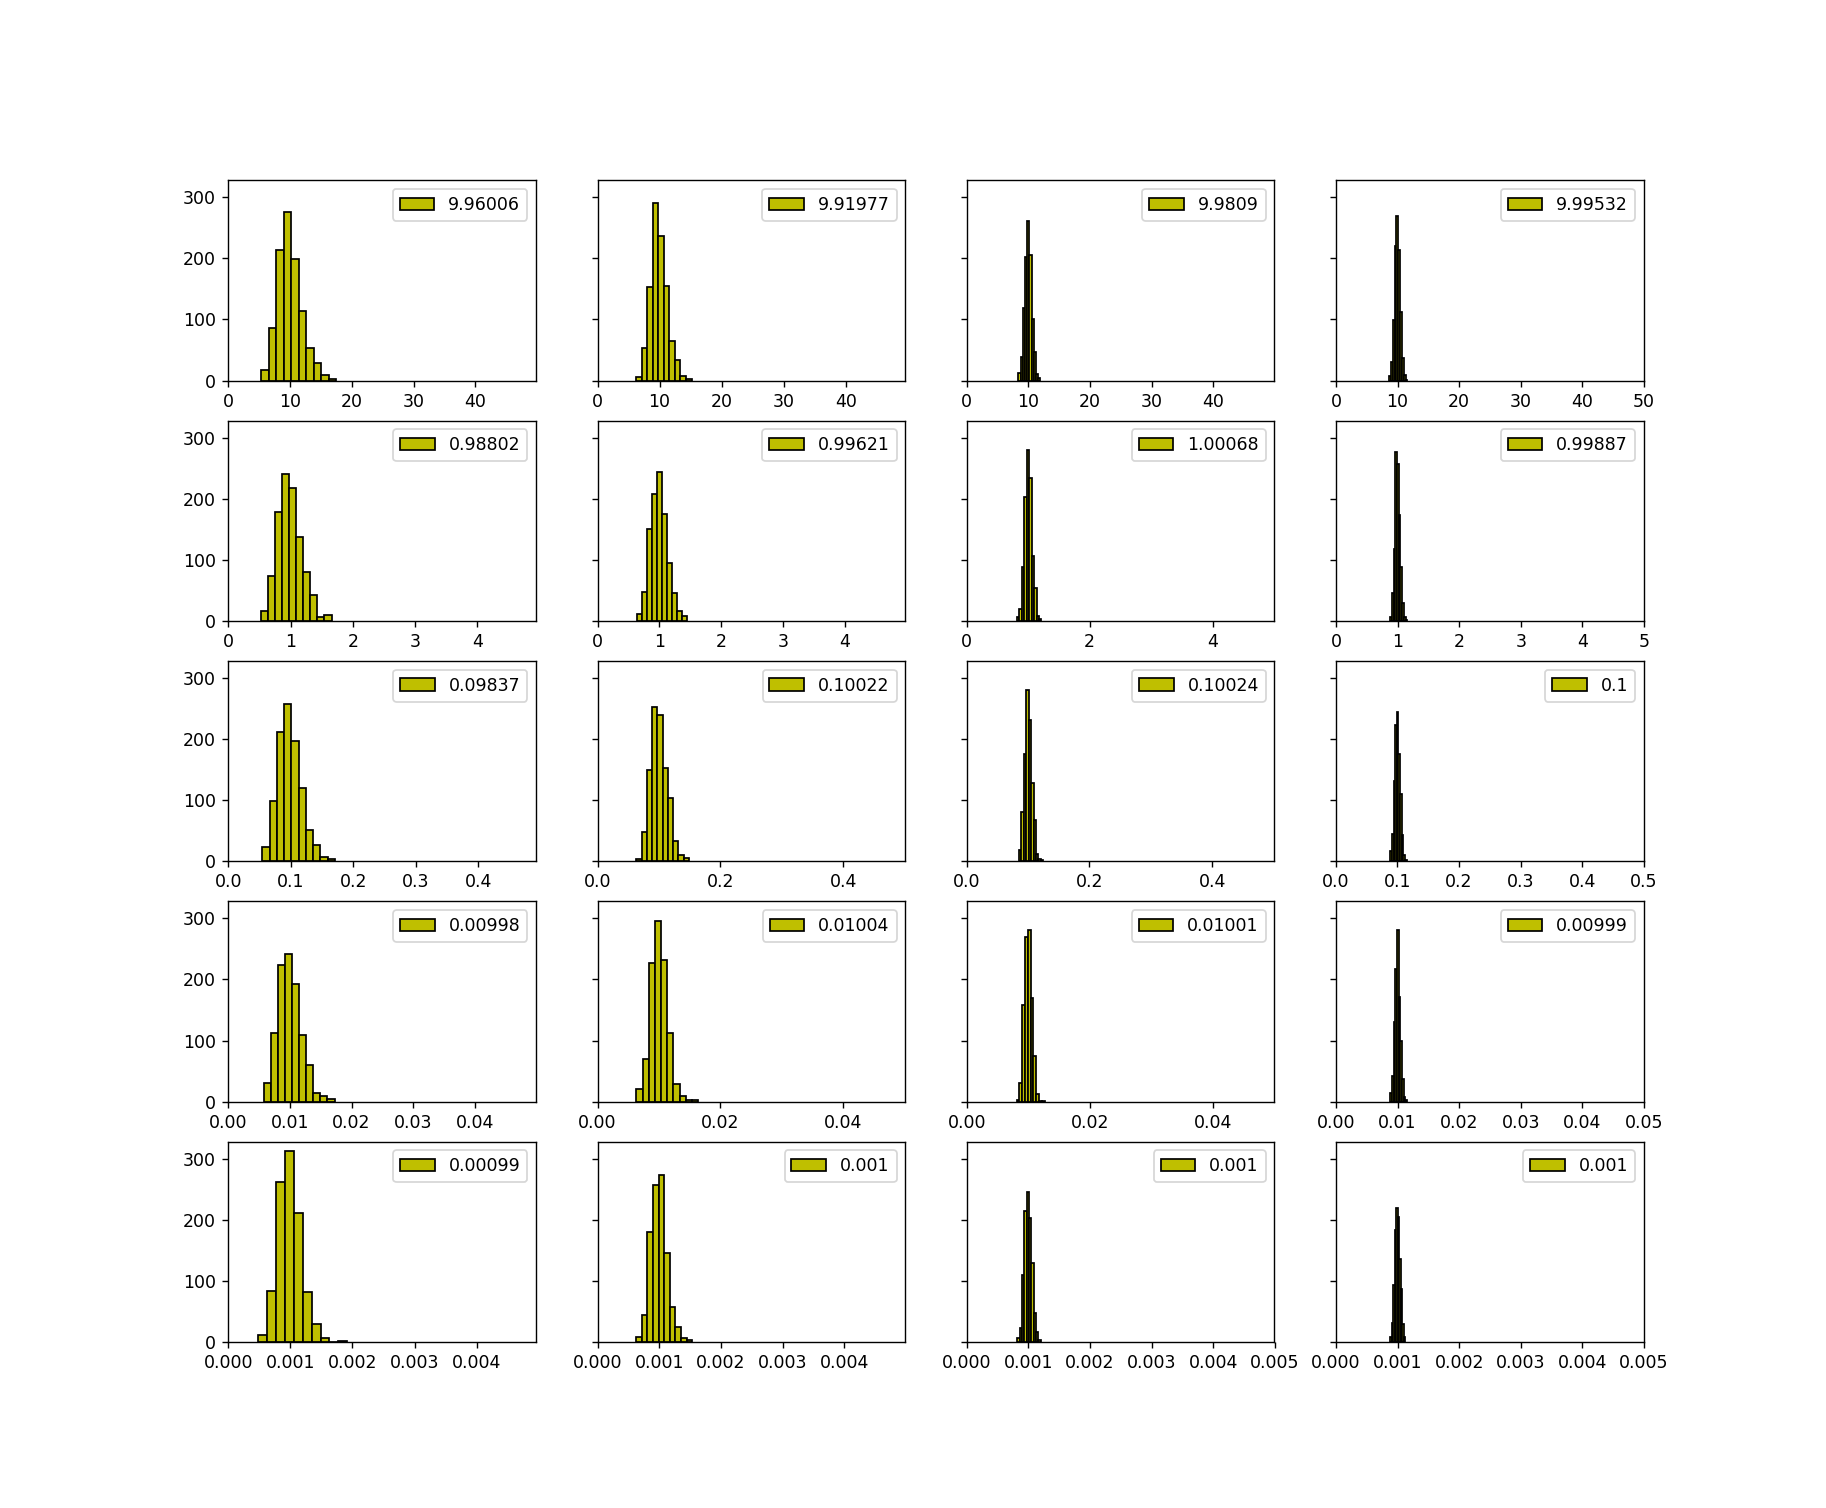

In [20]:
fig, axes = plt.subplots(nrows=5, ncols=4, sharey = True)
axlist = [i for i in axes.flat]
count = 0
for x in fitted_rates_surv_linear_fit:
    axlist[count].hist(x, facecolor = 'y', edgecolor = 'k', label = (str(round(np.mean(x),5))))
    axlist[count].legend(loc = 1,shadow=False, fancybox=True)
    axlist[count].set_xlim(0,5*np.mean(x))
    count+=1

Okay, it looks about the same, though maybe slightly under estimated on average...hmmm. Overall though, this is to be expected, our fits were already about as good as they could get. But there is a bit of a surprising result here. The linear fit is actually a little bit worse than the exponential fit. In retrospect, I should have realized that for the same reason I truncated the distribution, that I might not want to evenly weight all the terms in the survival curve. In fact, quite the opposite is true. It may even be the case that there exists an optimal truncation which maximaizes information and minimizes error. There is some precedent for this, for example, its true that when calculating the diffusion coefficient from the mean squared displacement (MSD), there exists an optimum extent of the MSD to use in the determination... curious.

  

Lets wrap it up then by plotting the span of expected rate values for each condition and analysis approach side by side.

<IPython.core.display.Javascript object>


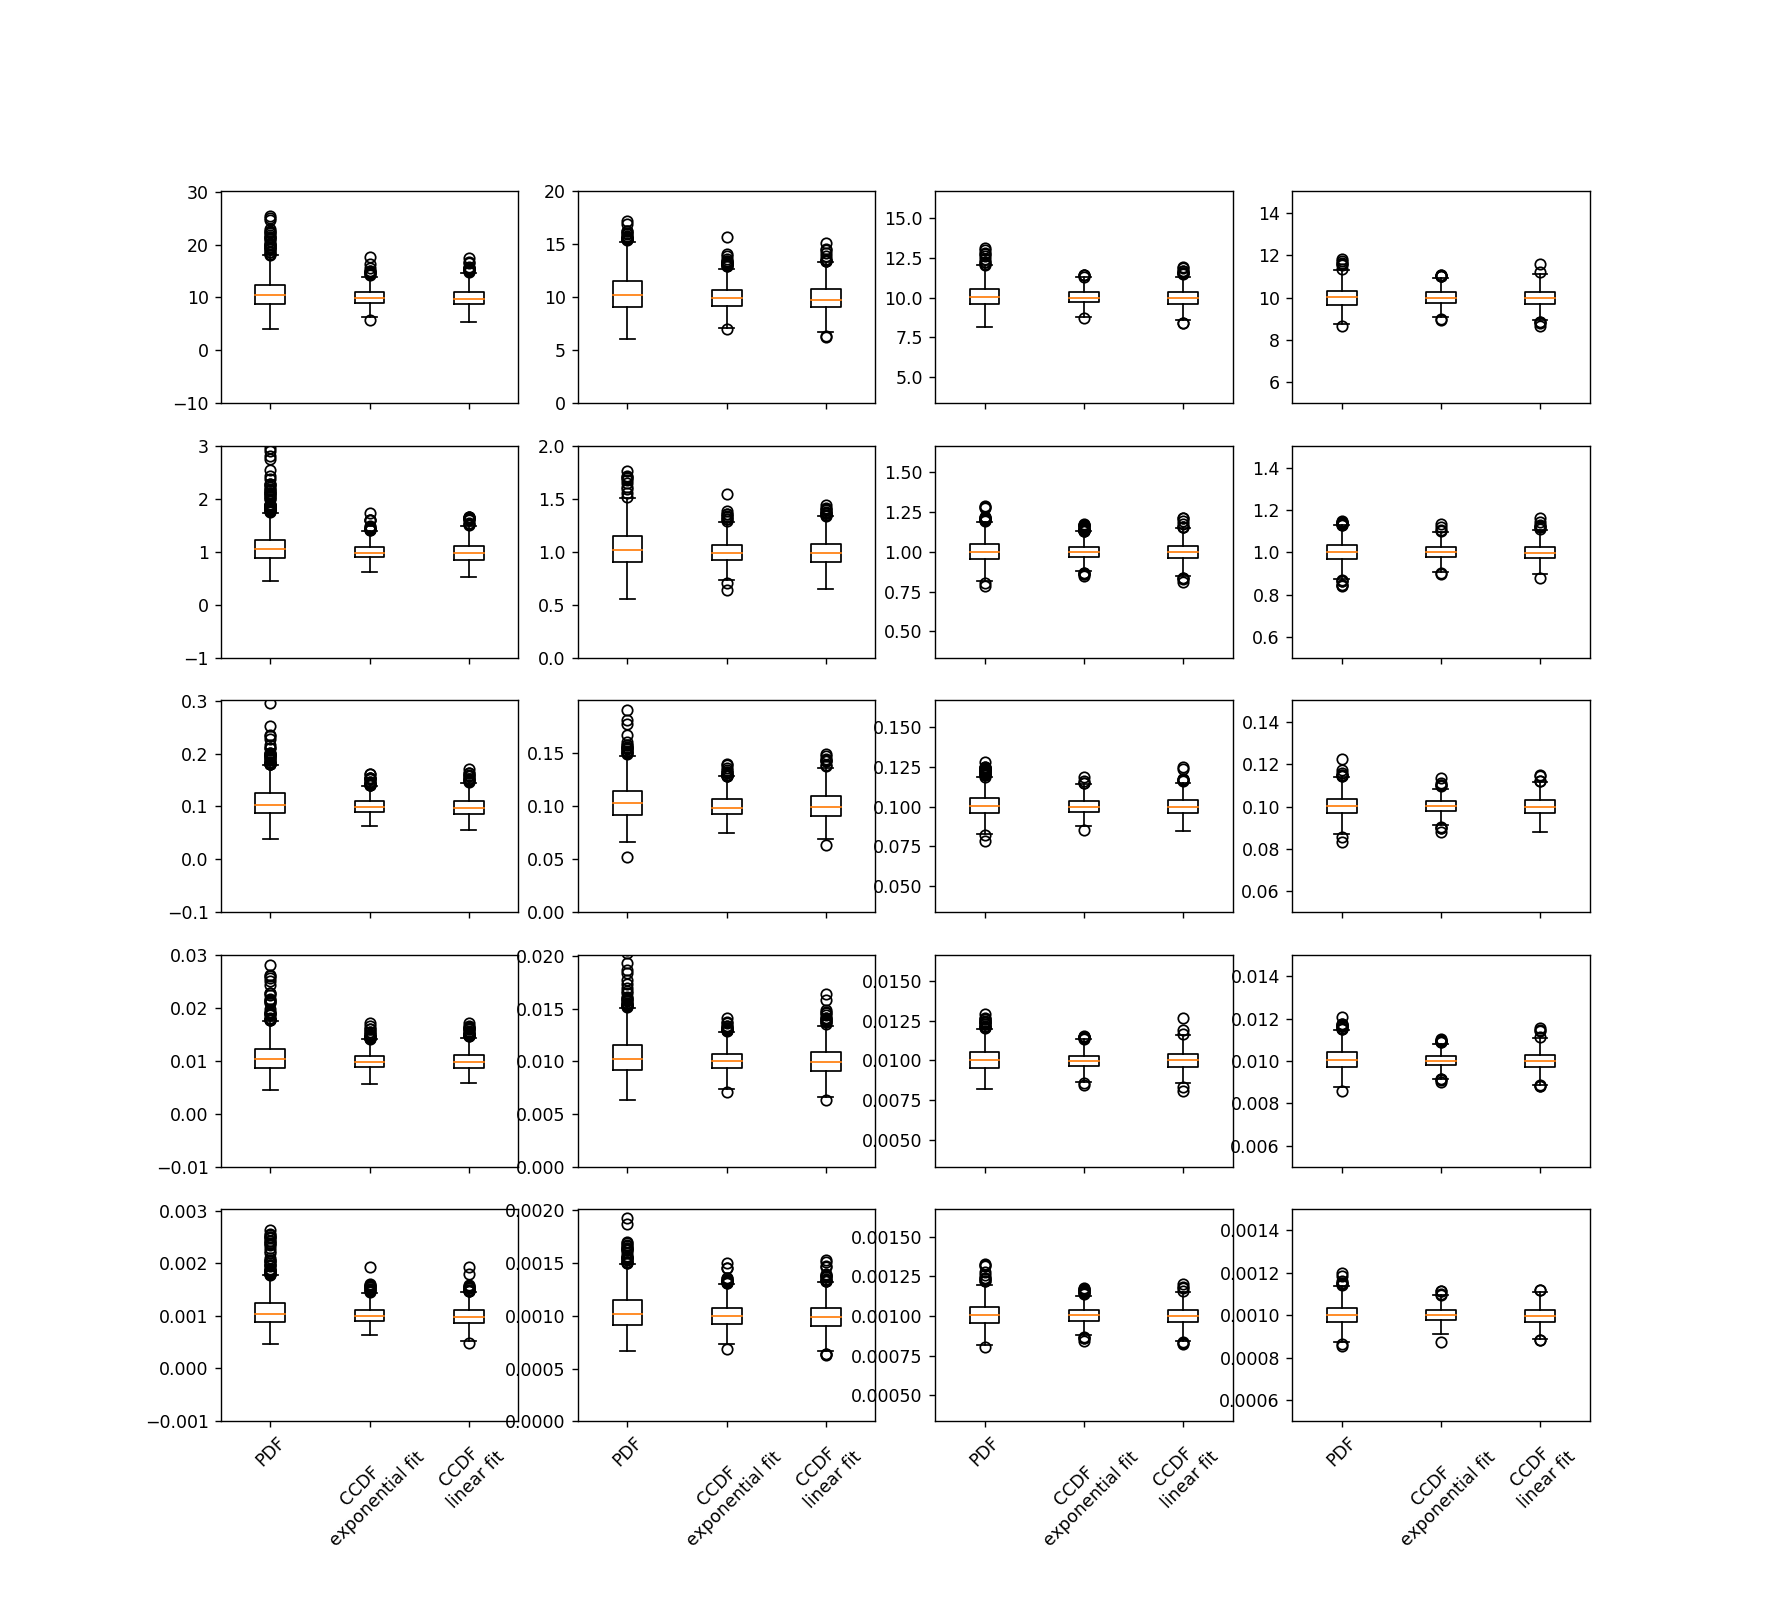

In [22]:
fig, axes = plt.subplots(nrows=5, ncols=4, sharex = True)
axlist = [i for i in axes.flat]
count = 0
labels = ["PDF","CCDF \nexponential fit","CCDF \nlinear fit"]
for i in range(len(fitted_rates_histfit)):
    axlist[count].boxplot([fitted_rates_histfit[i],fitted_rates_surv_log_fit[i],fitted_rates_surv_linear_fit[i]])
    mu = np.mean(fitted_rates_surv_log_fit[i])
    axlist[count].set_ylim(mu-(2/(count%4 +1))*mu, mu+(2/(count%4 +1))*mu)
    axlist[count].set_xticklabels(labels,rotation=45)
    count+=1